In [39]:
# TensorFlow and tf.keras

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
import tensorflow.keras.utils
import pandas as pd

# import keras
# import keras.backend
# from keras import layers
# from keras import models
# import keras.utils

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import time
import h5py
import sklearn
from sklearn.utils import shuffle

import os

2.0.0


## Import data

In [40]:
grid = 16
data = np.load('/mnt/data/ml/ShowJetsData_4cat.npz')
!ls /mnt/data/ml/
images = data['jetImages']
labels = data['labels']
grid = np.size(images, 1)
# radii = np.concatenate((traindata_sig['radiilab'], traindata_bkg['radiilab']), axis = 0)
# theta = np.concatenate((traindata_sig['thetalab'], traindata_bkg['thetalab']), axis = 0)
# z = np.concatenate((traindata_sig['zlab'], traindata_bkg['zlab']), axis = 0)
n_data = len(images)
testimages = images[::4]
testimages = testimages.reshape(len(testimages), grid,grid,1)
testlabels = labels[::4].reshape((len(testimages)), 4)
mask_im = np.ones(images.shape,dtype=bool)
mask_im[::4] = 0
mask_im[1::8] = 0
mask_lab = np.ones(labels.shape,dtype=bool)
mask_lab[::4] = 0
mask_lab[1::8] = 0
valimages = images[1::8]
valimages = images[1::8].reshape(len(valimages), grid,grid,1)
vallabels = labels[1::8].reshape((len(valimages)), 4)
trainimages = images[mask_im].reshape((n_data-len(testimages)-len(valimages)), grid, grid, 1)
trainlabels = labels[mask_lab].reshape((n_data-len(testimages)-len(valimages)), 4)

Constituent4vecData_4cat.npz	     gravkk_zz_3TeV_addsubstructure.root
Constituent4vecData_normed.npz	     gravkk_zz_3TeV_nsj.root
Constituent4vecData_NormedPt.npz     qcd_flat15to7000_addevnum.root
Constituent4vecData.npz		     qcd_flat15to7000_addsubstructure.root
gravkk_zz_1TeV_addevnum.root	     qcd_flat15to7000_nsj.root
gravkk_zz_1TeV_addsubstructure.root  ShowJetsData1TeV.npz
gravkk_zz_1TeV_nsj.root		     ShowJetsData_4cat.npz
gravkk_zz_2TeV_addevnum.root	     ShowJetsData_normed.npz
gravkk_zz_2TeV_addsubstructure.root  ShowJetsData_NormedPt.npz
gravkk_zz_2TeV_nsj.root		     ShowJetsData.npz
gravkk_zz_3TeV_addevnum.root


Print a plot of data to see what it looks like!

Preprocessing -> spit data into training and testing; take 80% for training and 20% for testing.

If using CNN, uncomment ".reshape(n_data, grid, grid, 1)".

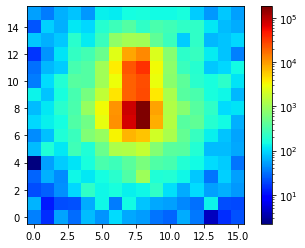

In [41]:
#plot input signal and background
sig_trainimages = np.zeros_like(trainimages[1])
bkg_trainimages = np.zeros_like(trainimages[1])
for i in range(len(trainimages)):
    if trainlabels[i,0] == 1:
        sig_trainimages += trainimages[i]
    else:
        bkg_trainimages += trainimages[i]
display_sig = sig_trainimages.reshape(grid,grid)
plt.grid(False)
plt.imshow(display_sig, interpolation='nearest', origin='low', cmap = 'jet', norm=LogNorm())
plt.colorbar()
plt.show()

Build DNN:

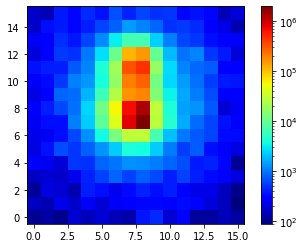

In [42]:
#background
display_bkg = bkg_trainimages.reshape(grid,grid)
plt.grid(False)
plt.imshow(display_bkg, interpolation='nearest', origin='low', cmap = 'jet', norm=LogNorm())
plt.colorbar()
plt.show()

In [43]:
def build_model():
    input1 = layers.Input(shape = (grid, grid, 1))
    x = layers.Conv2D(64, (12, 12), padding = 'same', activation='relu')(input1)
    x = layers.Conv2D(64, (6, 6), padding = 'same', activation='relu')(x)
    x = layers.Conv2D(64, (4, 4), padding = 'same', activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Conv2D(32, (4, 4), padding = 'same', activation='relu')(x)
    x = layers.Conv2D(32, (3, 3), padding = 'same', activation='relu')(x)
    x = layers.Conv2D(32, (2, 2), padding = 'same', activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)
#     x = layers.Conv2D(32, (6, 6), padding = 'same', activation='relu')(x)
#     x = layers.Conv2D(32, (4, 4), padding = 'same', activation='relu')(x)
#     x = layers.Conv2D(32, (4, 4), padding = 'same', activation='relu')(x)
#     x = layers.MaxPool2D((2, 2))(x)
    x = layers.Flatten()(x)
#     input2 = layers.Input(shape=(1,))
#     input3 = layers.Input(shape=(2,))
#     input4 = layers.Input(shape=(1,))
#     x = layers.concatenate(inputs = [x1, input2, input3, input4],axis=-1)
    x = layers.Dense(64, activation=tf.nn.relu)(x)
    x = layers.Dense(256, activation=tf.nn.relu)(x)
    x = layers.Dense(256, activation=tf.nn.relu)(x)
    output = layers.Dense(4, activation=tf.nn.softmax)(x)
    model = models.Model(inputs=input1, outputs=output)
    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['categorical_crossentropy', 'accuracy'])
    return model

Initialize model:

In [44]:
CNN = build_model()

Test model's prediction $before$ training:

In [45]:
example_batch = trainimages[::300]
example_labels = trainlabels[::300]
# example_radii = trainradii[:10]
# example_theta = traintheta[:10]
# example_z = trainz[:10]
example_result = CNN.predict(x = example_batch)
results = CNN.evaluate(x = example_batch, y = example_labels, verbose = 0)
print(example_result)
print(results)

[[0.21992086 0.23259036 0.28234133 0.26514742]
 [0.22474864 0.22761959 0.28591284 0.26171893]
 [0.21518753 0.22360352 0.30466655 0.25654238]
 [0.19598486 0.22166683 0.3058353  0.27651304]
 [0.23239663 0.21939929 0.29133606 0.25686803]
 [0.22894357 0.2297184  0.28413385 0.25720417]
 [0.1945765  0.2121274  0.30759698 0.2856991 ]
 [0.18888888 0.19356461 0.3441457  0.2734008 ]
 [0.21812266 0.24048162 0.27003044 0.27136528]
 [0.18914059 0.19909598 0.33396533 0.27779806]
 [0.22034091 0.21180789 0.29305226 0.27479896]
 [0.21988712 0.2292563  0.28389704 0.2669595 ]
 [0.21975812 0.2328591  0.2888444  0.2585383 ]
 [0.22815791 0.23893525 0.27028543 0.26262146]
 [0.12387422 0.12844032 0.4700127  0.2776727 ]
 [0.22405463 0.23849155 0.2727159  0.26473796]
 [0.21322975 0.21968642 0.2989651  0.26811874]
 [0.23479855 0.23918204 0.26795658 0.25806275]
 [0.21957536 0.23422061 0.28582948 0.2603746 ]
 [0.23174906 0.2435118  0.2712804  0.25345877]
 [0.22847489 0.23243003 0.2708911  0.26820394]
 [0.23204133 

Now train! (warning: if building CNN, computer tends to get loud)

In [46]:
checkpoint_path = "model/CNN_normedpythia.h5"
if not os.path.exists("model"):
    os.mkdir("model")

# Create checkpoint callback
# cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
#                                                  save_best_only=True,
#                                                  verbose=1)
model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', 
                                   verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto')    
EPOCHS = 50
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = CNN.fit(
  trainimages[::], trainlabels[::],
  epochs=EPOCHS, validation_data = (valimages[::], vallabels[::]), verbose = 1,
  callbacks=[early_stop, model_checkpoint])

Train on 10560 samples, validate on 2112 samples
Epoch 1/50
 1376/10560 [==>...........................] - ETA: 1:06 - loss: 1.2664 - categorical_crossentropy: 1.2664 - accuracy: 0.3527WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,categorical_crossentropy,accuracy


KeyboardInterrupt: 

Now make a plot that shows the pregression of accuracy through each training epoch.

In [9]:
# def plot_history(history):
#   hist = pd.DataFrame(history.history)
#   hist['epoch'] = history.epoch
  
#   plt.figure()
#   plt.xlabel('Epoch')
#   plt.ylabel('Mean Square Error')
#   plt.plot(hist['epoch'], hist['binary'],
#            label='Train Error')
#   plt.plot(hist['epoch'], hist['val_mean_squared_error'],
#            label = 'Val Error')
#   plt.ylim([0,100])
#   plt.legend()
#   plt.show()

# plot_history(history)

Load best weights.

In [35]:
!ls model
best_model = keras.models.load_model('model/CNN_allTeVpythia.h5')
best_model.summary()
results = best_model.evaluate(testimages, testlabels, verbose = 0)
print(results)

CNN_1TeVpythia.h5    CNN_cat_multi_input.h5  CNN_pythia.h5
CNN_allTeVpythia.h5  CNN_normedpythia.h5
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16, 16, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 64)        9280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        147520    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        65600     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          32800     
___________________________

Evaluate the performance of our DNN! Plot predictions vs. true values (the line is predictions vs. predicitons).

In [36]:
predict = best_model.predict(testimages)

[0. 0. 0. ... 0. 0. 0.]
[0.13044195 0.04676161 0.07697114 ... 0.0262116  0.0438919  0.03751116]


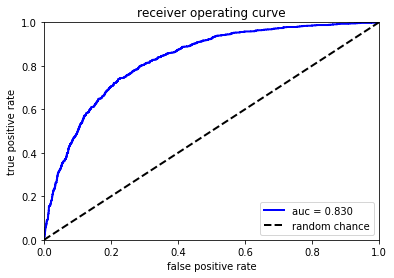

In [48]:
print(testlabels[:,0])
print(predict[:,0])
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(testlabels[:,2], predict[:,2])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label='auc = %.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('receiver operating curve')
plt.legend(loc="lower right")
plt.show()

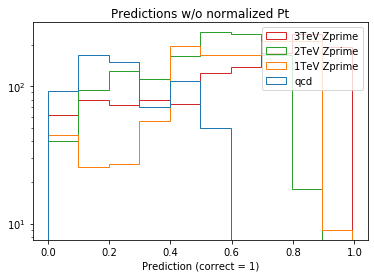

In [38]:
indqcd = np.argwhere(testlabels[:,0] == 1)
ind1  = np.where(testlabels[:,1] == 1) 
ind2  = np.where(testlabels[:,2] == 1)
ind3  = np.where(testlabels[:,3] == 1)
hist_, bin_edges_ = np.histogram(predict[indqcd])
plt.hist([predict[indqcd, 0].flatten(),predict[ind1, 1].flatten(), predict[ind2, 2].flatten(), predict[ind3, 3].flatten()] , histtype = 'step', label = ['qcd', '1TeV Zprime', '2TeV Zprime', '3TeV Zprime'])
plt.legend()
plt.title('Predictions w/o normalized Pt')
plt.yscale('log')
plt.xlabel('Prediction (correct = 1)')
plt.show()